# Xgboost model for predicting fraction of alteration

This notebook explains how to make the xgboost model for alteration as the outcome variable.

Alteration was recorded as >50-90% or >90% thus we use this as the outcome variable as a binary classifier.

First we install libraries that may not be presently installed.

In [1]:
!pip install xgboost
!pip install sklearn
!pip install shap

You should consider upgrading via the '/home/john/anaconda3/envs/borehole/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/john/anaconda3/envs/borehole/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/john/anaconda3/envs/borehole/bin/python3.8 -m pip install --upgrade pip' command.


Next we import libraries.

We set the random state as 42. This is because there are several stochastic pieces of the puzzle, such as how we separate the data for train and testing, etc. This prevents from this randomness creating different models. However, this should be tested at some point with different `random_states`.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import shap

random_state = 42

print('ezr')

D:\PycharmProjects\SerpRateAI\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
D:\PycharmProjects\SerpRateAI\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swa

ezr


In [2]:
data = pd.read_excel('D:/SerpRateAI/Dataset_BA1B_Final.xlsx')

In [3]:
data.head()

,CORE,SECTION,SECTION_UNIT,% of fractures,IMAGES,SEGMENTATION,TOP_DEPTH,UNIT_DESC4,VEIN_INTENSITY,ALTERATION,...,Branching,Blue patches,Magmatic intrusions,Hydrothermal,Rodingite,Magmatic veins,Offsets,Shearing,Dark green,Dunitic zone
0,1.0,1.0,1,0.689654,D:/SerpRateAI/Camera/CS_5057_5_B_1_1_1.jpg,D:/SerpRateAI/Results/CS_5057_5_B_1_1_1/CS_505...,0.00,NN,4.0,>90%,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,2,0.689654,D:/SerpRateAI/Camera/CS_5057_5_B_1_1_1.jpg,D:/SerpRateAI/Results/CS_5057_5_B_1_1_1/CS_505...,0.50,NN,3.0,>90%,...,0,0,0,0,0,0,0,0,0,0
2,NaN,2.0,1,0.659654,D:/SerpRateAI/Camera/CS_5057_5_B_1_2_1.jpg,D:/SerpRateAI/Results/CS_5057_5_B_1_2_1/CS_505...,0.91,NN,4.0,>90%,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,2,0.659654,D:/SerpRateAI/Camera/CS_5057_5_B_1_2_1.jpg,D:/SerpRateAI/Results/CS_5057_5_B_1_2_1/CS_505...,1.19,NN,4.0,>90%,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,3,0.659654,D:/SerpRateAI/Camera/CS_5057_5_B_1_2_1.jpg,D:/SerpRateAI/Results/CS_5057_5_B_1_2_1/CS_505...,1.60,NN,4.0,>90%,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.columns

Index(['CORE', 'SECTION', 'SECTION_UNIT', '% of fractures', 'IMAGES',
       'SEGMENTATION', 'TOP_DEPTH', 'UNIT_DESC4', 'VEIN_INTENSITY',
       'ALTERATION',
       ...
       'Branching', 'Blue patches', 'Magmatic intrusions', 'Hydrothermal',
       'Rodingite', 'Magmatic veins', 'Offsets', 'Shearing', 'Dark green',
       'Dunitic zone'],
      dtype='object', length=101)

# Picking what columns to use

Here I have created a list of columns and commented out `TOP_DEPTH` and `Magnetite`.

There are different kinds of columns and we should figure out which columns are worth keeping and which can stay.

I excluded all of the other columns that came from the original data set to see if only the columns that we generated are meaningful.

In [5]:
columns_to_keep = ['% of fractures'
                   # ,'TOP_DEPTH'
                   ,'ALTERATION',
                   ##### these are the hamed codes columns
'PnS2_sum', 'PnL_sum', 'PnP3V_sum', 'PnP3H_sum', 'PnP4_sum', 'PnP6V_sum', 'FnS2_sum', 'FnL_sum', 'FnP3V_sum', 'FnP3H_sum', 'FnP4_sum', 'FnP6V_sum',
                   ##### these are the keywords created by chatgpt
                   'Veins', 'Serpentine vein', 'Oxidation', 'Carbonate veins', 'Network', 'Dyke', 'Black serpentinization', 'White veins', 'Open cracks',
                   #'Dunite',
                    'Gabbro', 'Microgabbro','Green veins','Open crack',
                   #'Irregular',
                  'Waxy green','Alteration','Subvertical','Fine grained','Subhorizontal','Lineation'
                   # ,'Magnetite'
                   ,'Thickness',
                   # 'Harzburgite',
                   'Altered gabbro','Offset','Altered','Crack','Pxenites','Microbio sample','Bulk serp','Bulk','Coalescence','Waxy','Wavy','Slickensides','Alteration halo','Plagioclase','Fracture','Sheared','Pyroxenite','Striations','Branching','Blue patches','Magmatic intrusions','Hydrothermal','Rodingite','Magmatic veins','Offsets','Shearing','Dark green','Dunitic zone',]

In [6]:
data = data[columns_to_keep]

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


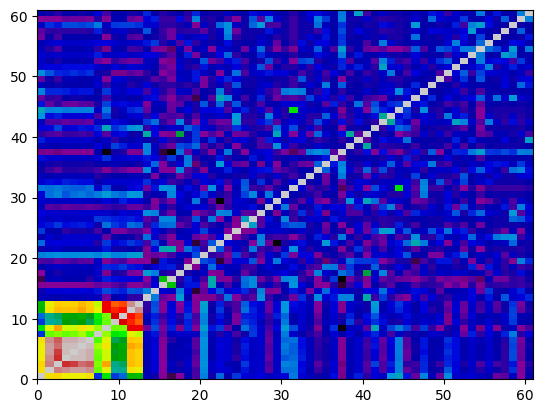

In [7]:
plt.pcolormesh(data.corr().values, cmap='nipy_spectral')

In [8]:
# in some cases we are missing images therefore there is no data available for those sections
data.dropna(inplace=True)

In [9]:
# Separate features and target variable
X = data.drop('ALTERATION', axis=1)
y = data['ALTERATION']

In [10]:
# replace the alteration values with 1 or 0 to make it easier for codes to run
y.replace('>90%', 1, inplace=True)
y.replace('50%-90%', 0, inplace=True)
y.unique()

array([1, 0], dtype=int64)

In [11]:
data['ALTERATION'].sum() / data.shape[0]

0.4058219178082192

In [12]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


# Xgboost

*The below text was created with the help of chatgpt*

XGBoost (eXtreme Gradient Boosting) is a popular machine learning algorithm that belongs to the gradient boosting framework. It is an ensemble method that combines multiple weak prediction models (typically decision trees) to create a powerful predictive model.

Here's a step-by-step explanation of how an XGBoost model works:

**Initialization:** The XGBoost algorithm starts with an initial prediction called the "base model." This prediction can be a simple constant value or a simple model like the mean of the target variable.

**Loss Calculation:** The algorithm calculates the difference between the base model's predictions and the actual target values. This difference is known as the "residuals" or "errors." The choice of loss function depends on the problem type (e.g., regression, binary classification, multiclass classification) and determines how the residuals are penalized.

**Building Decision Trees (Weak Learners):** XGBoost builds decision trees as weak learners to learn from the residuals. Each decision tree is constructed in a greedy manner, recursively splitting the data based on features that minimize the loss function.

**Tree Construction:** The construction of each decision tree involves the following steps:

1. **Split Finding:** XGBoost considers different split points for each feature and selects the one that results in the greatest reduction of the loss function.
2. **Pruning:** To control overfitting, XGBoost incorporates regularization techniques such as maximum depth, minimum child weight, and gamma (minimum loss reduction required for a node to split).

**Updating Predictions:** After constructing the decision tree, XGBoost calculates the predicted values using the tree. The predictions are added to the previous base model's predictions, creating an updated set of predictions.

**Loss Update:** XGBoost calculates the loss between the updated predictions and the actual target values. This loss is used to determine the performance improvement achieved by the current decision tree.

**Ensemble Building:** The newly constructed decision tree is added to the ensemble of weak learners. The predictions from all the trees are combined, and the algorithm repeats steps 2-7 for a specified number of iterations (boosting rounds).

**Final Prediction:** After all the boosting rounds, the final prediction is obtained by summing the predictions from all the weak learners. For regression problems, this is a straightforward sum. For classification problems, a logistic transformation or a softmax function is applied to obtain class probabilities.

**Regularization:** XGBoost applies regularization techniques such as learning rate (shrinkage), subsampling of the training instances, and column subsampling (feature importance estimation) to prevent overfitting and improve generalization.

**Model Evaluation:** XGBoost evaluates the model's performance using evaluation metrics specific to the problem type, such as mean squared error (MSE) for regression or area under the ROC curve (AUC-ROC) for binary classification.

The key strengths of XGBoost include its ability to handle mixed data types, handle missing values, handle large datasets with parallel processing, and offer flexibility in customization through various hyperparameters.

Overall, XGBoost's iterative boosting process, tree construction, and ensemble learning contribute to its ability to create powerful predictive models with high accuracy and strong generalization capabilities.

In [13]:
# Create an XGBoost DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_test.columns, enable_categorical=True)

print('ezr')

ezr


In [15]:
# Set XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': random_state
}

print('ezr')

ezr


In [16]:
# Train the XGBoost classifier with 5-fold cross-validation
cv_results = xgb.cv(params, dtrain, num_boost_round=10000, nfold=5, stratified=True, early_stopping_rounds=10, seed=random_state)
print('ezr')

ezr


In [17]:
# Determine the optimal number of boosting rounds
best_num_boost_rounds = cv_results.shape[0]

# Retrain the model with the optimal number of boosting rounds
model = xgb.train(params, dtrain, num_boost_round=best_num_boost_rounds)

In [18]:
# Make predictions on the test set
y_pred = model.predict(dtest)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.9198679471788715


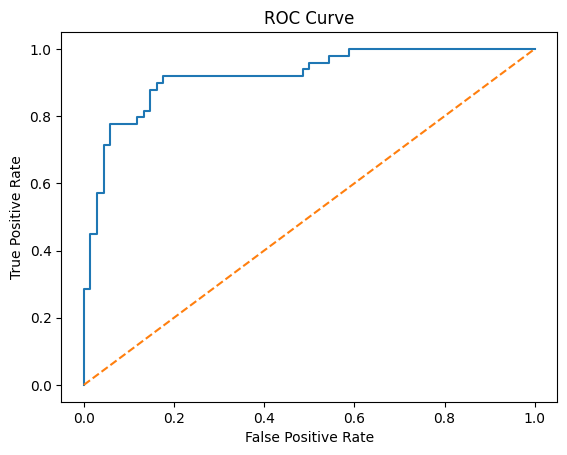

In [19]:
# Compute false positive rate and true positive rate for ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

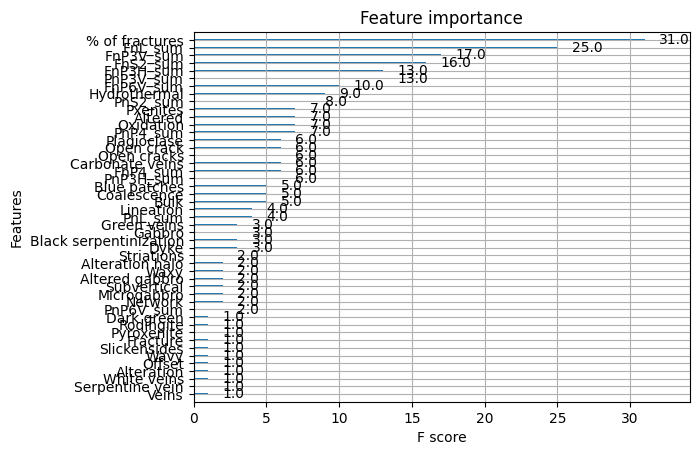

In [20]:
# # Plot feature importances
xgb.plot_importance(model)
plt.show()

In [21]:
# Calculate SHAP values
explainer = shap.KernelExplainer(model.predict, dtrain)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type='bar')
plt.show()

# Plot SHAP dependence plot
feature_index = 0  # Index of the feature to plot
shap.dependence_plot(feature_index, shap_values, X_test, interaction_index=None)
plt.show()

AssertionError: Unknown type passed as data object: <class 'xgboost.core.DMatrix'>

In [22]:
# Create a beeswarm plot for SHAP values
shap.summary_plot(shap_values, X_test, plot_type="violin", show=False)
plt.show()

# Next steps

1. removing all the features until the model no longer works

In [22]:
data

,% of fractures,ALTERATION,PnS2_sum,PnL_sum,PnP3V_sum,PnP3H_sum,PnP4_sum,PnP6V_sum,FnS2_sum,FnL_sum,...,Branching,Blue patches,Magmatic intrusions,Hydrothermal,Rodingite,Magmatic veins,Offsets,Shearing,Dark green,Dunitic zone
2,0.659654,1,0.012611,0.007953,0.003510,0.003379,0.004335,0.003224,1.564736,3.047126,...,0,0,0,0,0,0,0,0,0,0
3,0.659654,1,0.012611,0.007953,0.003510,0.003379,0.004335,0.003224,1.564736,3.047126,...,0,0,0,0,0,0,0,0,0,0
4,0.659654,1,0.012611,0.007953,0.003510,0.003379,0.004335,0.003224,1.564736,3.047126,...,0,0,0,0,0,0,0,0,0,0
6,6.188315,1,0.848076,0.428770,0.168830,0.192490,0.197865,0.139404,7.954393,4.481620,...,0,0,0,0,0,0,0,0,0,0
7,6.513009,1,0.794560,0.486881,0.172372,0.169760,0.212686,0.141606,5.729705,6.004427,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,0.934813,0,0.064930,0.041012,0.020782,0.020356,0.023933,0.018813,6.292350,2.490708,...,0,0,0,0,0,0,0,0,0,0
651,2.736685,0,0.552802,0.249188,0.118913,0.119031,0.136784,0.099092,5.858591,3.225693,...,0,0,0,0,0,1,0,0,0,1
652,4.180412,0,0.460758,0.198235,0.094984,0.095003,0.109533,0.078279,4.081176,3.238340,...,0,0,0,0,0,0,0,0,0,0
653,4.180412,0,0.460758,0.198235,0.094984,0.095003,0.109533,0.078279,4.081176,3.238340,...,0,0,0,0,0,0,0,0,0,0
